In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from scipy.io import arff
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import keras.backend as K
from keras import regularizers
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from multi_label_metrics import *
from label_info import label_counter
import seaborn as sns
tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
Adam = tf.keras.optimizers.Adam


In [2]:
#fix the random seed for comparison
from numpy.random import seed
seed(12)
from tensorflow.random import set_seed
set_seed(34)

data,_ = arff.loadarff(r'./dataset/yeast/yeast.arff')
df = pd.DataFrame(data) 
df=df.sample(frac=1, random_state=1) #shuffle the data
rows,cols = df.shape
input_dim = cols-14
output_dim = 14

df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
535,0.155765,0.106403,-0.035367,-0.136857,-0.284304,-0.153110,-0.319761,-0.156661,-0.053910,0.181384,...,b'0',b'0',b'0',b'0',b'1',b'1',b'0',b'1',b'1',b'0'
936,0.067438,-0.086640,0.016308,-0.131930,0.092059,-0.155763,0.045003,-0.054296,0.046792,0.018881,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
1815,-0.009172,0.005135,-0.068527,-0.059437,-0.193989,0.126675,-0.184806,0.117865,0.066552,0.096871,...,b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'1',b'1',b'0'
297,-0.018043,-0.030532,0.006394,0.037218,0.048662,0.054159,-0.180368,0.141720,0.126975,-0.029195,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
1065,0.520272,0.112940,0.018493,0.020344,-0.022716,-0.034295,-0.059520,-0.012996,-0.063361,-0.073279,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


In [3]:
split_index = int(rows * 0.8)
data_train:pd.DataFrame = df.iloc[:split_index,:]
data_test:pd.DataFrame = df.iloc[split_index:,:]
x_train = np.array(data_train.iloc[:,:-14].values,dtype ='float32')
y_train = np.array(data_train.iloc[:,-14:].values,dtype ='int')
x_test = np.array(data_test.iloc[:,:-14].values,dtype ='float32')
y_test = np.array(data_test.iloc[:,-14:].values,dtype ='int')

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))
label_info = label_counter(X,Y)
train_size = np.shape(x_train)[0]
train_size
for l in range(len(label_info)):
    print("Number of instances with %s positive label(s): %s" %(l,label_info[l].astype("int32")))


Number of instances with 0 positive label(s): 0
Number of instances with 1 positive label(s): 32
Number of instances with 2 positive label(s): 412
Number of instances with 3 positive label(s): 112
Number of instances with 4 positive label(s): 1102
Number of instances with 5 positive label(s): 173
Number of instances with 6 positive label(s): 415
Number of instances with 7 positive label(s): 102
Number of instances with 8 positive label(s): 55
Number of instances with 9 positive label(s): 9
Number of instances with 10 positive label(s): 4
Number of instances with 11 positive label(s): 1
Number of instances with 12 positive label(s): 0
Number of instances with 13 positive label(s): 0
Number of instances with 14 positive label(s): 0


In [4]:
def create_model():
    kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(train_size, dtype='float32'))

    model = tf.keras.models.Sequential([
          Dense(
              160,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              80,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              50,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              40, activation='relu', dtype ='float32'),
          Dense(
              30, activation='relu', dtype ='float32'),
          tfp.layers.DenseFlipout(
              output_dim, kernel_divergence_fn=kl_divergence_function,activation='sigmoid', dtype ='float32'),
  ])
    return model
model = create_model()

C:\Users\zhang\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\zhang\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


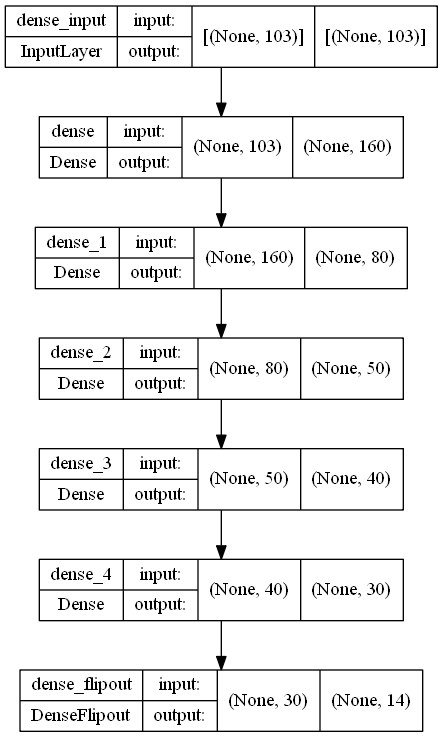

In [5]:

plot_model(model, to_file='./Model_Last_Layer_BNN_Yeast.png', show_shapes=True)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               16640     
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 50)                4050      
                                                                 
 dense_3 (Dense)             (None, 40)                2040      
                                                                 
 dense_4 (Dense)             (None, 30)                1230      
                                                                 
 dense_flipout (DenseFlipout  (None, 14)               854       
 )                                                               
                                                        

In [7]:
model.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(lr=1e-3),metrics=['binary_accuracy',hamming_loss,precision_micro,recall_micro,f1_micro])

C:\Users\zhang\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train,y_train,epochs=100,batch_size=256,validation_split=0.25,shuffle=True)

Epoch 1/100
6/6 [==============================] - 2s 83ms/step - loss: 1.2489 - binary_accuracy: 0.4272 - hamming_loss: 0.5720 - precision_micro: 0.2718 - recall_micro: 0.5274 - f1_micro: 0.3585 - val_loss: 1.2384 - val_binary_accuracy: 0.4628 - val_hamming_loss: 0.5365 - val_precision_micro: 0.3076 - val_recall_micro: 0.6452 - val_f1_micro: 0.4166
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 1.2265 - binary_accuracy: 0.5840 - hamming_loss: 0.4098 - precision_micro: 0.4042 - recall_micro: 0.6232 - f1_micro: 0.4852 - val_loss: 1.2061 - val_binary_accuracy: 0.6957 - val_hamming_loss: 0.3037 - val_precision_micro: 0.4902 - val_recall_micro: 0.5479 - val_f1_micro: 0.5173
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 1.1845 - binary_accuracy: 0.7187 - hamming_loss: 0.2808 - precision_micro: 0.5418 - recall_micro: 0.5270 - f1_micro: 0.5331 - val_loss: 1.1479 - val_binary_accuracy: 0.7289 - val_hamming_loss: 0.2711 - val_precision_micro: 0.5

6/6 [==============================] - 0s 9ms/step - loss: 0.9530 - binary_accuracy: 0.8059 - hamming_loss: 0.1939 - precision_micro: 0.7198 - recall_micro: 0.5948 - f1_micro: 0.6511 - val_loss: 0.9718 - val_binary_accuracy: 0.7974 - val_hamming_loss: 0.2026 - val_precision_micro: 0.6889 - val_recall_micro: 0.5788 - val_f1_micro: 0.6291
Epoch 25/100
6/6 [==============================] - 0s 8ms/step - loss: 0.9481 - binary_accuracy: 0.8063 - hamming_loss: 0.1935 - precision_micro: 0.7195 - recall_micro: 0.5970 - f1_micro: 0.6525 - val_loss: 0.9700 - val_binary_accuracy: 0.7987 - val_hamming_loss: 0.2012 - val_precision_micro: 0.6898 - val_recall_micro: 0.5860 - val_f1_micro: 0.6336
Epoch 26/100
6/6 [==============================] - 0s 8ms/step - loss: 0.9409 - binary_accuracy: 0.8097 - hamming_loss: 0.1904 - precision_micro: 0.7231 - recall_micro: 0.6074 - f1_micro: 0.6601 - val_loss: 0.9682 - val_binary_accuracy: 0.8006 - val_hamming_loss: 0.1992 - val_precision_micro: 0.6892 - val_r

6/6 [==============================] - 0s 8ms/step - loss: 0.8153 - binary_accuracy: 0.8614 - hamming_loss: 0.1387 - precision_micro: 0.8104 - recall_micro: 0.7103 - f1_micro: 0.7569 - val_loss: 1.0113 - val_binary_accuracy: 0.7856 - val_hamming_loss: 0.2143 - val_precision_micro: 0.6553 - val_recall_micro: 0.5869 - val_f1_micro: 0.6192
Epoch 48/100
6/6 [==============================] - 0s 8ms/step - loss: 0.8101 - binary_accuracy: 0.8651 - hamming_loss: 0.1355 - precision_micro: 0.8188 - recall_micro: 0.7127 - f1_micro: 0.7620 - val_loss: 1.0220 - val_binary_accuracy: 0.7844 - val_hamming_loss: 0.2154 - val_precision_micro: 0.6546 - val_recall_micro: 0.5805 - val_f1_micro: 0.6153
Epoch 49/100
6/6 [==============================] - 0s 9ms/step - loss: 0.8048 - binary_accuracy: 0.8648 - hamming_loss: 0.1346 - precision_micro: 0.8226 - recall_micro: 0.7098 - f1_micro: 0.7620 - val_loss: 1.0113 - val_binary_accuracy: 0.7879 - val_hamming_loss: 0.2120 - val_precision_micro: 0.6598 - val_r

6/6 [==============================] - 0s 9ms/step - loss: 0.6988 - binary_accuracy: 0.9026 - hamming_loss: 0.0967 - precision_micro: 0.8753 - recall_micro: 0.7961 - f1_micro: 0.8337 - val_loss: 1.1479 - val_binary_accuracy: 0.7723 - val_hamming_loss: 0.2273 - val_precision_micro: 0.6248 - val_recall_micro: 0.5846 - val_f1_micro: 0.6040
Epoch 71/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6943 - binary_accuracy: 0.9016 - hamming_loss: 0.0995 - precision_micro: 0.8701 - recall_micro: 0.7928 - f1_micro: 0.8296 - val_loss: 1.1581 - val_binary_accuracy: 0.7717 - val_hamming_loss: 0.2281 - val_precision_micro: 0.6237 - val_recall_micro: 0.5830 - val_f1_micro: 0.6027
Epoch 72/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6901 - binary_accuracy: 0.9043 - hamming_loss: 0.0955 - precision_micro: 0.8754 - recall_micro: 0.8007 - f1_micro: 0.8363 - val_loss: 1.1564 - val_binary_accuracy: 0.7733 - val_hamming_loss: 0.2266 - val_precision_micro: 0.6262 - val_r

6/6 [==============================] - 0s 8ms/step - loss: 0.6244 - binary_accuracy: 0.9238 - hamming_loss: 0.0761 - precision_micro: 0.9029 - recall_micro: 0.8402 - f1_micro: 0.8703 - val_loss: 1.3075 - val_binary_accuracy: 0.7642 - val_hamming_loss: 0.2360 - val_precision_micro: 0.6067 - val_recall_micro: 0.5830 - val_f1_micro: 0.5946
Epoch 94/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6188 - binary_accuracy: 0.9255 - hamming_loss: 0.0747 - precision_micro: 0.9070 - recall_micro: 0.8407 - f1_micro: 0.8726 - val_loss: 1.3272 - val_binary_accuracy: 0.7708 - val_hamming_loss: 0.2290 - val_precision_micro: 0.6222 - val_recall_micro: 0.5809 - val_f1_micro: 0.6008
Epoch 95/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6204 - binary_accuracy: 0.9231 - hamming_loss: 0.0772 - precision_micro: 0.9057 - recall_micro: 0.8333 - f1_micro: 0.8679 - val_loss: 1.3289 - val_binary_accuracy: 0.7705 - val_hamming_loss: 0.2295 - val_precision_micro: 0.6183 - val_r

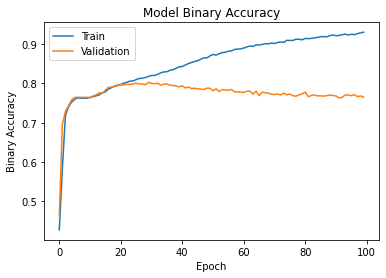

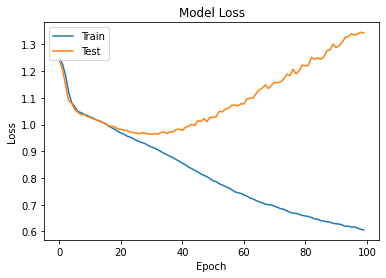

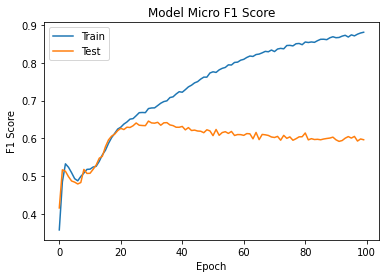

In [9]:
#Visualisation
#acc
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#f1
plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model Micro F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [10]:
loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro = model.evaluate(x_test, y_test)
print('Test:')
print('Loss: %s\nBinary-Accuracy(the same as Micro-Accuracy): %s \nHamming_Loss: %s \nMicro-Precision: %s \nMicro-Recall: %s \nMicro-F1 Score: %s' % (loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro))

16/16 [==============================] - 0s 1ms/step - loss: 1.4048 - binary_accuracy: 0.7546 - hamming_loss: 0.2437 - precision_micro: 0.5952 - recall_micro: 0.5645 - f1_micro: 0.5778
Test:
Loss: 1.404754638671875
Binary-Accuracy(the same as Micro-Accuracy): 0.7545748353004456 
Hamming_Loss: 0.243722066283226 
Micro-Precision: 0.5952465534210205 
Micro-Recall: 0.5645186305046082 
Micro-F1 Score: 0.577789843082428


In [11]:
y_pred = model.predict(x_test)

In [12]:
np.sum(y_test,axis=1)

array([ 4,  4,  5,  4,  4,  6,  6,  8,  4,  4,  6,  6,  2,  4,  7,  2,  2,
        4,  4,  6,  7,  2,  4,  3,  2,  2,  3,  5,  6,  5,  4,  6,  4,  4,
        4,  4,  2,  4,  4,  4,  6,  6,  6,  4,  4,  4,  3,  2,  4,  2,  6,
        4,  4,  3,  3,  4,  2,  7,  2,  3,  7,  4,  3,  4,  4,  2,  6,  4,
        8,  4,  5,  2,  6,  4,  4,  6,  2,  4,  4,  2,  3,  6,  2,  6,  4,
        2,  4,  4,  2,  4,  6,  4,  6,  5,  2,  4,  4,  6,  2,  4,  4,  4,
        3,  3,  5,  2,  4,  4,  6,  2,  7,  6,  4,  2,  3,  5,  2,  4,  6,
        6,  4,  5,  3,  4,  4,  3,  4,  8,  2,  8,  7,  7,  4,  4,  4,  4,
        4,  4,  6,  2,  6,  2,  4,  6,  6,  2,  4,  4,  6,  5,  5,  2,  4,
        4,  4,  2,  4,  2,  4,  4,  5,  6,  6,  4,  4,  4,  4,  3,  8,  2,
        4,  1,  7,  4,  4,  5,  4,  4,  4,  4,  6,  4,  6,  4,  6,  2,  6,
        5,  6,  3,  4,  4,  2,  7,  2,  7,  6,  8,  6,  4,  4,  4,  3,  2,
        4,  4,  6,  3,  4,  5,  4,  6,  4,  5,  2,  4,  4,  4,  4,  4,  2,
        4,  4,  4,  2,  6

In [13]:
y_test[14]

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0])

In [14]:
y_test[293]

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [15]:
loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro = model.evaluate(x_test, y_test)
print('Test:')
print('Loss: %s\nBinary-Accuracy(the same as Micro-Accuracy): %s \nHamming_Loss: %s \nMicro-Precision: %s \nMicro-Recall: %s \nMicro-F1 Score: %s' % (loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro))

16/16 [==============================] - 0s 1ms/step - loss: 1.4092 - binary_accuracy: 0.7575 - hamming_loss: 0.2429 - precision_micro: 0.5955 - recall_micro: 0.5734 - f1_micro: 0.5827
Test:
Loss: 1.4092200994491577
Binary-Accuracy(the same as Micro-Accuracy): 0.7575266361236572 
Hamming_Loss: 0.2428850531578064 
Micro-Precision: 0.5954807996749878 
Micro-Recall: 0.573417603969574 
Micro-F1 Score: 0.5827054977416992


In [16]:
y_pred = model.predict(x_test)

In [17]:
instance_1 = np.reshape(x_test[14],(1,103))
instance_2 = np.reshape(x_test[293],(1,103))

In [18]:
num_ensemble = 500
y_pred_all_idx1 = []
y_pred_all_idx2 = []
y_pred_all = []
for e in range(num_ensemble):
    
    y_pred_idx1 = model.predict(instance_1)
    y_pred_all_idx1.append(y_pred_idx1)
    y_pred_idx2 = model.predict(instance_2)
    y_pred_all_idx2.append(y_pred_idx2)
    y_pred = model.predict(x_test)
    y_pred_all.append(y_pred)

In [19]:
y_pred_m_1 = np.mean(y_pred_all_idx1, axis=0)
y_pred_s_1 = np.std(y_pred_all_idx1, axis=0)
y_pred_m_2 = np.mean(y_pred_all_idx2, axis=0)
y_pred_s_2 = np.std(y_pred_all_idx2, axis=0)
y_pred_m = np.mean(y_pred_all,axis=0)
y_pred_s = np.std(y_pred_all,axis=0)

In [20]:
labels=np.linspace(1,14,14)


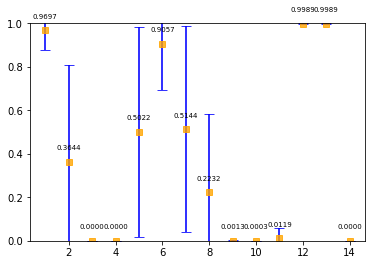

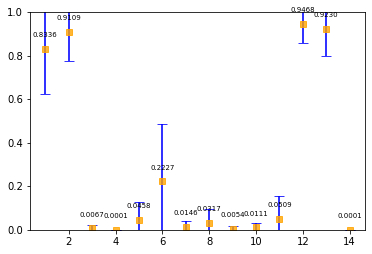

In [21]:
plt.errorbar(labels,y_pred_m_1[0],yerr=1.96*y_pred_s_1[0],fmt='s',ecolor='blue',color='orange',elinewidth=2,capsize=5,alpha=0.8)
plt.ylim((0, 1))
for a,b in zip(labels,y_pred_m_1[0]):
    plt.text(a, b+0.05, '%.4f' % b, ha='center', va= 'bottom',fontsize=7)
plt.savefig("./Last_Layer_BNN_Prediction_Exemple_1_Yeast.jpg" ,bbox_inches="tight")    
plt.show()
plt.errorbar(labels,y_pred_m_2[0],yerr=1.96*y_pred_s_2[0],fmt='s',ecolor='blue',color='orange',elinewidth=2,capsize=5,alpha=0.8)
plt.ylim((0, 1))
for a,b in zip(labels,y_pred_m_2[0]):
    plt.text(a, b+0.05, '%.4f' % b, ha='center', va= 'bottom',fontsize=7)
plt.savefig("./Last_Layer_BNN_Prediction_Exemple_2_Yeast.jpg" ,bbox_inches="tight")  
plt.show()

In [22]:
y_pred_m #ensemble's mean predictive value used for ECE and Reliability Diagramm

array([[3.9667124e-03, 6.1401916e-03, 2.6761237e-01, ..., 9.9997002e-01,
        9.9996203e-01, 5.8889226e-03],
       [1.2573188e-03, 3.3212279e-04, 4.1500046e-03, ..., 1.0000000e+00,
        1.0000000e+00, 4.1075706e-05],
       [3.3861536e-01, 8.3842605e-01, 8.7870973e-01, ..., 1.0506807e-01,
        8.9229003e-02, 2.2608852e-03],
       ...,
       [7.6826282e-02, 4.9905264e-01, 3.4051660e-02, ..., 7.8315395e-01,
        7.9327899e-01, 4.6458759e-04],
       [2.3002779e-01, 9.8705238e-01, 9.9814403e-01, ..., 8.5080749e-01,
        8.7147439e-01, 1.8354340e-03],
       [3.0653706e-02, 1.0589452e-01, 8.4990084e-01, ..., 9.9927270e-01,
        9.9893409e-01, 5.0937640e-03]], dtype=float32)

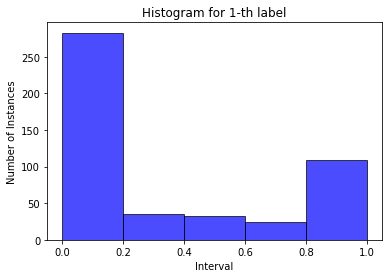

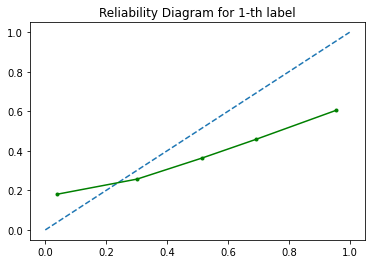

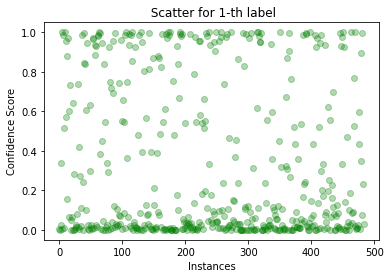

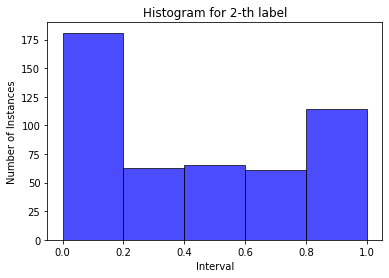

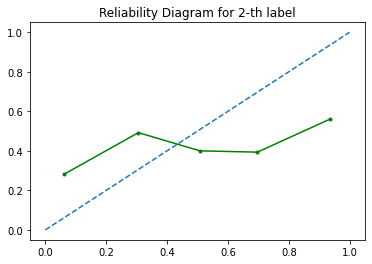

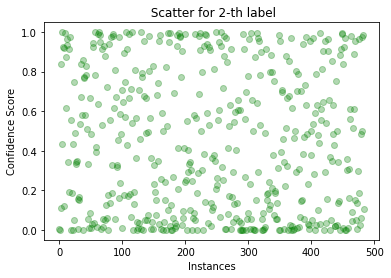

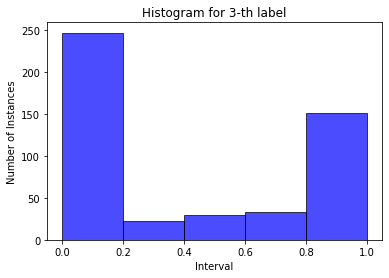

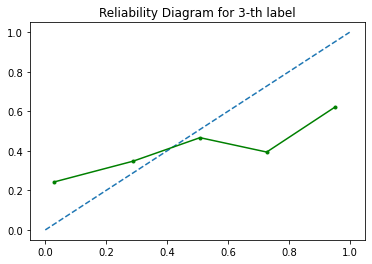

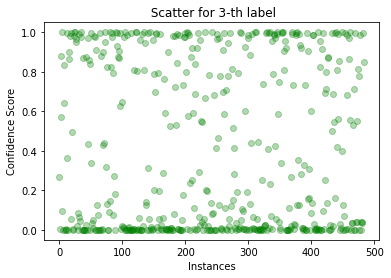

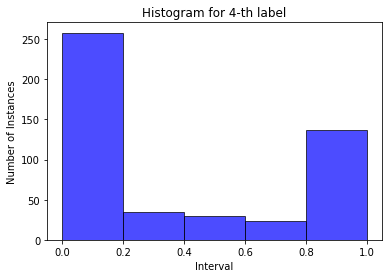

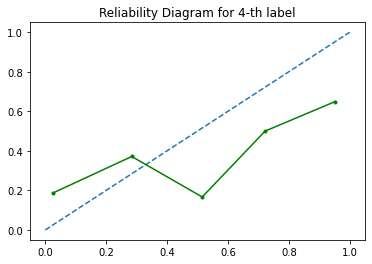

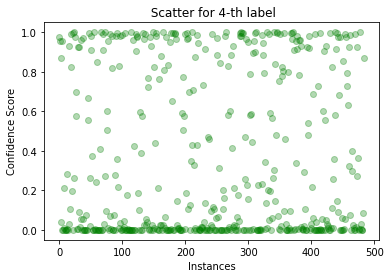

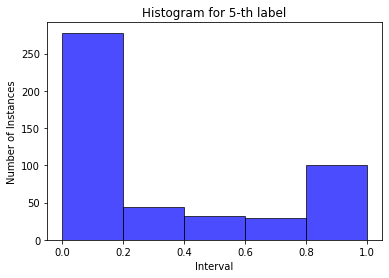

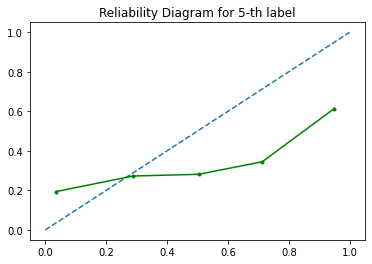

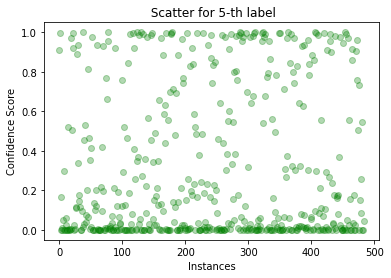

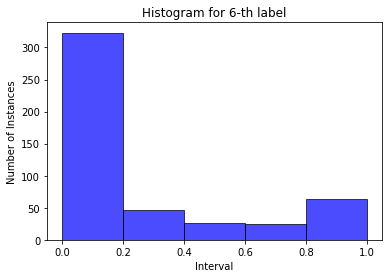

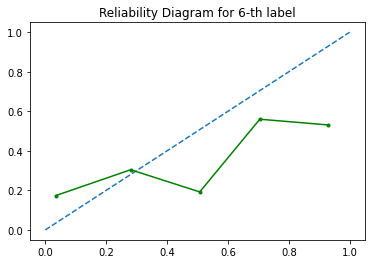

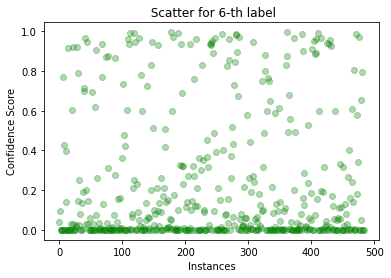

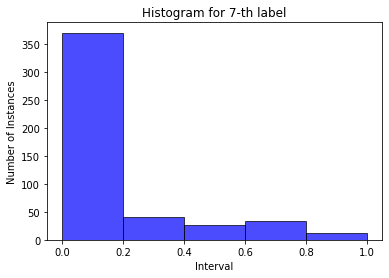

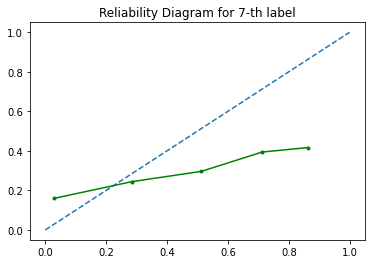

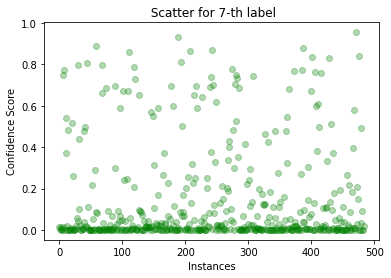

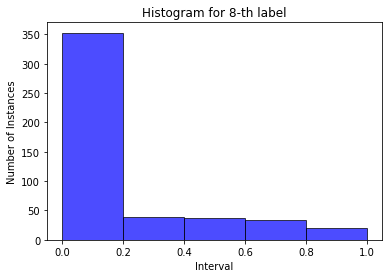

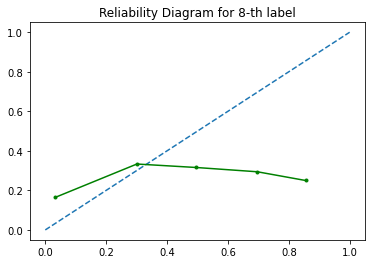

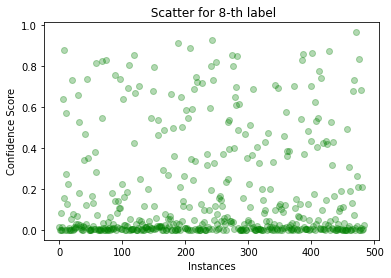

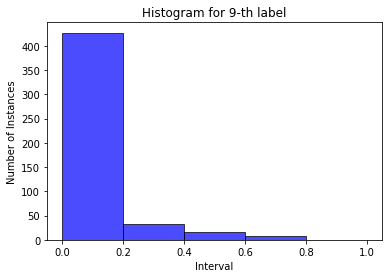

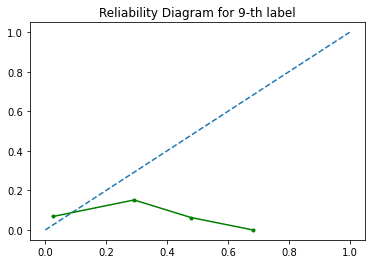

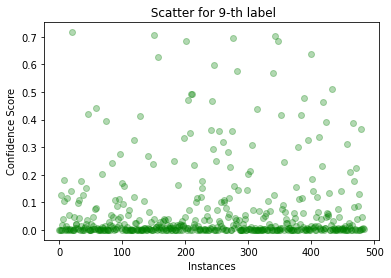

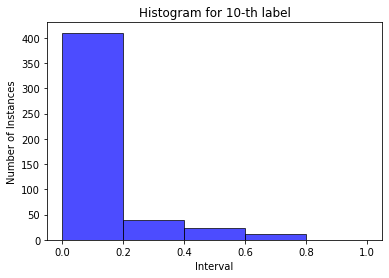

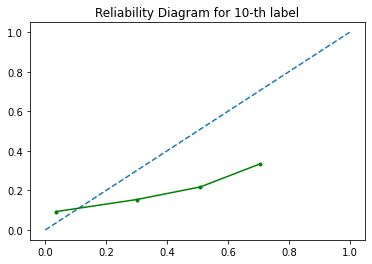

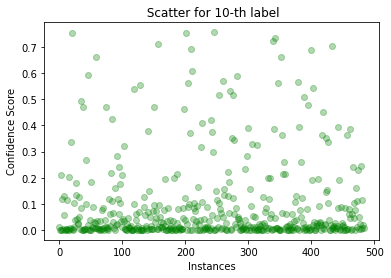

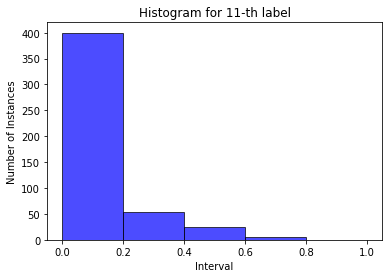

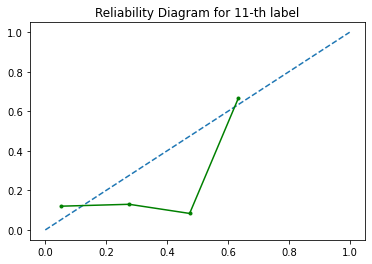

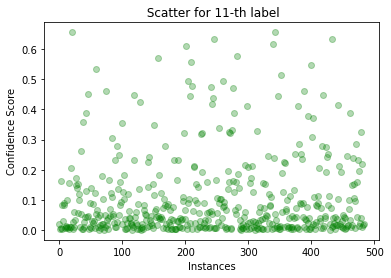

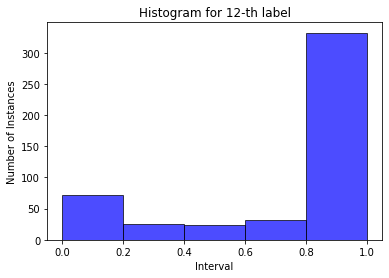

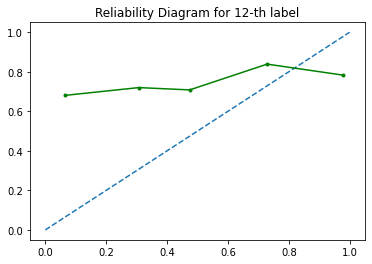

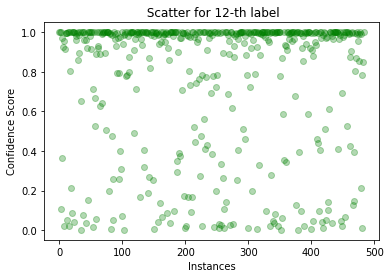

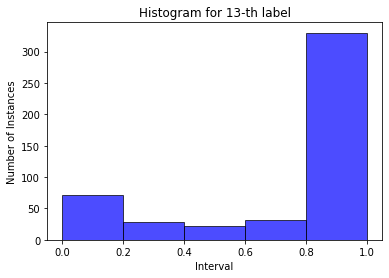

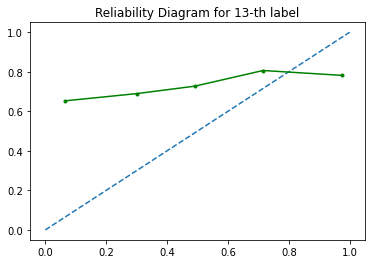

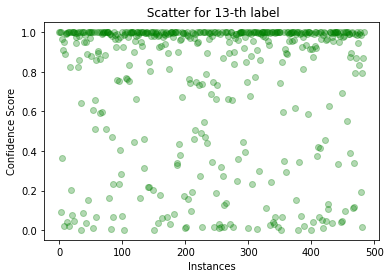

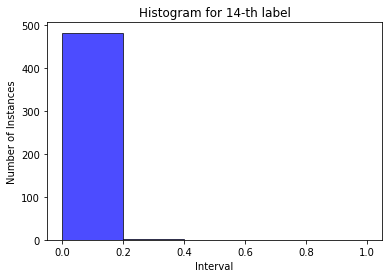

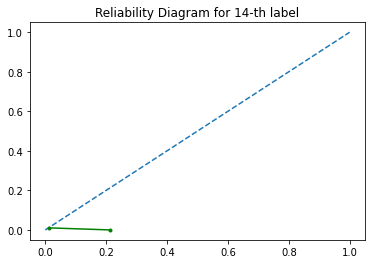

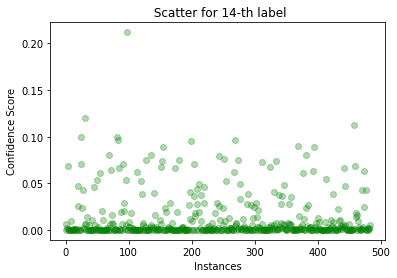

Expected Calibration Error for each label = [0.18743071607467912, 0.24769762881071208, 0.24001267762476117, 0.21109008671738083, 0.1988344156864149, 0.17218779500436127, 0.14909610854612632, 0.16636630875470548, 0.07232507702164537, 0.08357525077583187, 0.0934870876684847, 0.26525596465505585, 0.2590595844087733, 0.001981562488422095]
Average Expected Calibration Error for all labels = 0.16774287601695392


In [23]:
from sklearn.calibration import calibration_curve
from BM import bm_counter
#Histograms of predictive value and reliability diagrams to show non-calibration 
ECE=[]
ECE_cal = []
bins =5
for i in range(np.shape(y_test)[1]):
    #histogram
    plt.hist(y_pred_m[:,i],bins = bins,range=(0,1),facecolor="blue", edgecolor="black", alpha=0.7)
    plt.title('Histogram for %s-th label' %(i+1))
    plt.ylabel('Number of Instances')
    plt.xlabel('Interval')
    plt.savefig("./Last_Layer_BNN_Yeast_Hist_%s.jpg" %(i+1))
    plt.show()
    
    #reliability diagram
    prob_true, prob_pred = calibration_curve(y_test[:,i], y_pred_m[:,i], n_bins=bins) #acc for each bin, avg pred for each bin 
    Bm = bm_counter(y_pred_m[:,i],bins)
    Bm = Bm[Bm != 0]
    temp_ece=np.sum(abs(prob_pred - prob_true)*Bm)/np.shape(y_pred_m)[0]
    ECE.append(temp_ece)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.',label = 'uncalibrated',color = "green")
    plt.title('Reliability Diagram for %s-th label' %(i+1))
    plt.savefig("./Last_Layer_BNN_Yeast_RD_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    plt.scatter(range(np.shape(y_pred_m)[0]),y_pred_m[:,i],color = "green",label = ' uncalibrated',alpha= 0.3)
    plt.title(' Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./Yeast_Scatter_Last_Layer_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
print('Expected Calibration Error for each label = %s' %ECE)
avg_ECE = np.mean(ECE)
print('Average Expected Calibration Error for all labels = %s' %avg_ECE)

C:\Users\zhang\Desktop\Jupyter Notebook\multi_label_metrics.py:27: RuntimeWarning: invalid value encountered in true_divide
  precision_each_label = true_positives / predicted_positives


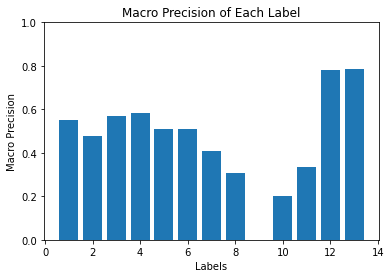

In [24]:
predictions = (y_pred_m > 0.5).astype("int32")
plt.bar(range(1,15),precision_macro(y_test,predictions)[0])
plt.ylim((0, 1))
plt.title('Macro Precision of Each Label')
plt.ylabel('Macro Precision')
plt.xlabel('Labels')
plt.savefig("./BNN_yeast_macro_precision.jpg" )

In [25]:
recall_macro(y_test,predictions)

(array([0.5704698 , 0.51020408, 0.60846561, 0.62275449, 0.51020408,
        0.42276423, 0.25263158, 0.2244898 , 0.        , 0.09433962,
        0.06557377, 0.78648649, 0.79234973, 0.        ]),
 0.3900523764507403)

In [26]:
precision_macro(y_test,predictions)


(array([0.55194805, 0.47619048, 0.56930693, 0.58426966, 0.51020408,
        0.50980392, 0.40677966, 0.30555556, 0.        , 0.2       ,
        0.33333333, 0.78225806, 0.78378378,        nan]),
 nan)

In [27]:
f1_macro(y_test,predictions)

C:\Users\zhang\Desktop\Jupyter Notebook\multi_label_metrics.py:33: RuntimeWarning: invalid value encountered in true_divide
  f1_each_label = 2*((p*r)/(p+r))


(array([0.56105611, 0.49261084, 0.58823529, 0.60289855, 0.51020408,
        0.46222222, 0.31168831, 0.25882353,        nan, 0.12820513,
        0.10958904, 0.78436658, 0.78804348,        nan]),
 nan)

In [28]:
accuracy_each_label(y_test,predictions)

array([0.72520661, 0.57438017, 0.66735537, 0.71694215, 0.70247934,
       0.75      , 0.78099174, 0.73966942, 0.90289256, 0.85950413,
       0.86570248, 0.66942149, 0.67768595, 0.98966942])

In [29]:
np.mean(accuracy_each_label(y_test,predictions))

0.7587072018890201

In [30]:
ECE_BL = [0.22966073587096672, 0.2937380143724553, 0.2676948459811434, 0.24749136095744653, 0.20517822161235577, 0.22045273556409667, 0.1844037048211576, 0.21670107965540347, 0.07825502153415319, 0.14050009719320655, 0.15896685985316236, 0.27666416377167824, 0.26626765155910354, 0.027148854647859863]

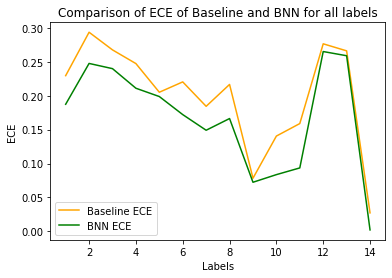

In [31]:
#calibrated model for test data evaluation Macro
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14],ECE_BL, label="Baseline ECE",color = "orange")
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14],ECE,color = "green",label = 'BNN ECE')
plt.title('Comparison of ECE of Baseline and BNN for all labels')
plt.ylabel('ECE')
plt.xlabel('Labels')
plt.legend()
plt.savefig("./yeast_ece_comparison_BNN.jpg" )
plt.show()